In [1]:
import time
from geopy.geocoders import Nominatim 
import reverse_geocoder as rg
import pandas as pd
import geopy.distance as gd
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import vincenty
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, '../Assignment1/')
from weighted_avg import calc_inv_weighted_avg

We implemented the grid of points within Alameda County by encapsulating the county within latitude / longitude borders and using the `reverse_geocoder` library to check whether points are in the county. We started with the given point near Summit Reservoir, and iterated 5 miles in the proper directions, updating the change in latitude / longitude every time based on the current point using `geopy.distance.vincenty`, which is one method of calculating geodesic distance.

The algorithm ends when the point passes the southern and eastern borders that we designated.

In [2]:
def get_alameda_county_points():
    """ Calculates all the grid points (lat, lon) inside Alameda County
    Grid automatically includes Summit Reservoir (37.905098, -122.272225)
    Begin at northwest corner of bounding box and move in increment of 5 miles
    in the south and east directions until we reach the southeast corner,
    recording all grid points that fall inside Alameda County.

    return:
        list: list of (lat, lon) points inside Alameda County
    """

    # bounding box around Alameda County
    north = 38
    west = -122.4
    south = 37.4
    east = -121.4
    
    

    # grid automatically includes Summit Reservoir (37.905098, -122.272225)
    grid = [(37.905098, -122.272225)]
    curr = [north, west]

    # while current point is within the north / south bounds
    while curr[0] > south:
        destE = vincenty(miles=5).destination(curr, 90) # point 5 miles east of curr
        lon_increment = destE.longitude - curr[1]
        
        destS = vincenty(miles=5).destination(curr, 180) # point 5 miles south of curr
        lat_increment = curr[0] - destS.latitude
        
        # while current point is within the east / west bounds
        while curr[1] < east:
            if (rg.search(curr)[0]['admin2'] == "Alameda County"):
                grid.append(tuple(curr))
            curr[1] += lon_increment
        curr[0] -= lat_increment
        curr[1] = west

    return grid

In [3]:
grid = get_alameda_county_points()

Loading formatted geocoded file...


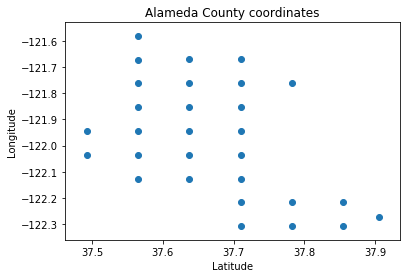

In [4]:
lat_list = []
lon_list = []
for lat, lon in grid:
    lat_list.append(lat)
    lon_list.append(lon)
    
plt.scatter(lat_list,lon_list)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Alameda County coordinates")
plt.show()

We find weather stations within *x* miles of Alameda County by using our grid as a proxy for the county. For each point in the grid, we parse through the dataset of weather stations and include each weather station that's within the *x* mile radius of the point. We mantain a set of included weather stations to eliminate duplicates in our list. 

In [5]:
def get_stations(grid_points, max_distance=10):
    """ Find all weather stations within max_distance (miles) from each of the grid points

    args:
        grid_points: list of grid points (lat, lon)
        max_distance: max distance to search around each grid point (default 10)
    return:
        list: list of weather stations (Series objects)
    """
    station_data = pd.read_csv('./data/stations_ca.csv')

    seen_stations = set()
    stations = []

    for point in grid_points:
        for index, station in station_data.iterrows():
            station_loc = (station['LATITUDE'], station['LONGITUDE'])
            if gd.vincenty(point, station_loc).miles <= max_distance and index not in seen_stations:
                seen_stations.add(index)
                stations.append(station)
    
    return stations

We get station weights by taking the latitude and longitude coordinates for all of our weather stations / Alameda county grid points, then calculating the inverse weighted averages for these coordinates.

In [6]:
def get_station_weights(grid_points, max_distance=10):
    """ Returns a list of weights corresponding to all the weather stations around grid points

    args:
        grid_points: list of grid points (lat, lon)
        max_distance: max distance to search around each grid point (default 10) 
    return:
        list: list of station weights (floats), one for each station
    """
    stations = get_stations(grid_points, max_distance)
    station_pos = [(station['LATITUDE'], station['LONGITUDE']) for station in stations]
    station_weights = calc_inv_weighted_avg(grid_points, station_pos)
    return station_weights

In [7]:
station_weights = get_station_weights(grid)

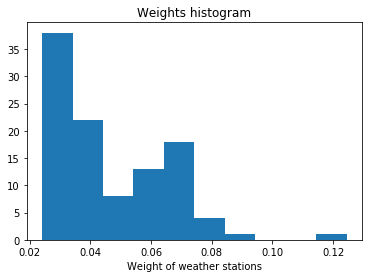

In [8]:
plt.hist(station_weights)
plt.xlabel("Weight of weather stations")
plt.title("Weights histogram")
plt.show()